# Fetch and parse feature importance results under a given directory

This script collects all feature importance results files under a given root directory, parses them, and aggregates them into a more easily digestable pandas DataFrame.

In [1]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

Set the local path to the root results directory:

In [2]:
RESULTS_ROOT_DIR = Path("/fast/groups/sf") / "folktexts-results" / "2024-07-03"

Set the local path to the root data directory (needed only to train baseline ML methods):

In [3]:
DATA_DIR = Path("/fast/groups/sf") / "data"

Function to parse and flatten results:

In [4]:
import operator
from functools import reduce

def parse_results_dict(dct: dict) -> dict:
    return reduce(
        operator.or_,
        [{
            f"{feat}_imp_mean": dct[feat]["imp_mean"],
            f"{feat}_imp_std": dct[feat]["imp_std"]
        } for feat in dct],
    )
            

Iteratively search the root directory for results files matching the given regex:

In [5]:
from utils import find_files, load_json
import re

# Results file name pattern
pattern = r'^feature-importance[.](?P<task>\w+)[.](?P<model>.*?)[.]json$'

# Find results files and aggregate
from collections import defaultdict
results = defaultdict(dict)

for file_path in tqdm(find_files(RESULTS_ROOT_DIR, pattern)):
    m = re.match(pattern, Path(file_path).name)
    results[m["task"]][m["model"]] = parse_results_dict(load_json(file_path))

if len(results) == 0:
    raise RuntimeError(f"Couldn't find any results at {RESULTS_ROOT_DIR}")

0it [00:00, ?it/s]

Aggregate results into a single DataFrame, and generate a unique identifier for each row:

In [6]:
llms_df = pd.DataFrame(results["ACSIncome"].values(), results["ACSIncome"].keys())
print(f"{llms_df.shape=}")

llms_df.shape=(20, 20)


In [7]:
# Currently discarding Gemma 2 results as some extra analysis is needed:
llms_df = llms_df[["gemma-2-" not in id_.lower() for id_ in llms_df.index]]

In [8]:
from utils import prettify_model_name

# Add prettified model name
llms_df["model_name"] = [prettify_model_name(m[m.find("--")+2:]) for m in llms_df.index]
llms_df = llms_df.sort_values("model_name")

llms_df.head(2)

,AGEP_imp_mean,AGEP_imp_std,COW_imp_mean,COW_imp_std,MAR_imp_mean,MAR_imp_std,OCCP_imp_mean,OCCP_imp_std,POBP_imp_mean,POBP_imp_std,...,RAC1P_imp_std,RELP_imp_mean,RELP_imp_std,SCHL_imp_mean,SCHL_imp_std,SEX_imp_mean,SEX_imp_std,WKHP_imp_mean,WKHP_imp_std,model_name
google--gemma-2b,0.030893,0.003416,0.005972,0.001597,0.004709,0.002058,0.033321,0.004408,0.011186,0.003455,...,0.002855,0.004928,0.002963,0.047764,0.002630,-0.000595,0.002619,0.009022,0.003113,Gemma 2B
google--gemma-1.1-2b-it,0.057288,0.001795,0.002239,0.000988,0.003562,0.000592,0.054559,0.001415,0.002923,0.000761,...,0.000334,0.010951,0.000447,0.073909,0.001346,0.003064,0.000409,0.028131,0.001265,Gemma 2B (it)


In [9]:
import re
all_features = [m["name"] for col in llms_df.columns if (m := re.fullmatch(r"^(?P<name>[a-zA-Z0-9]+)_imp_mean$", col))]

feat_imp_cols = [f"{col}_imp_mean" for col in all_features]
feat_imp_std_cols = [f"{col}_imp_std" for col in all_features]

all_features

['AGEP', 'COW', 'MAR', 'OCCP', 'POBP', 'RAC1P', 'RELP', 'SCHL', 'SEX', 'WKHP']

## Get feature importance for GBM and LR

In [10]:
%%time
from folktexts.acs.acs_dataset import ACSDataset
acs_income_dt = ACSDataset.make_from_task(task="ACSIncome", cache_dir=DATA_DIR)

Loading ACS data...
CPU times: user 43.1 s, sys: 26.9 s, total: 1min 10s
Wall time: 1min 19s


In [11]:
X_train, y_train = acs_income_dt.get_train()
X_test, y_test = acs_income_dt.get_test()

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier    # NOTE: requires `pip install xgboost`

baselines = {
    "GBM": HistGradientBoostingClassifier(),
    "LR": LogisticRegression(),
    "XGBoost": XGBClassifier(),
}

In [13]:
def parse_feat_imp_results(results) -> dict:
    parsed_dict = dict()
    for idx, feat in enumerate(X_train.columns.tolist()):
        parsed_dict[f"{feat}_imp_mean"] = results["importances_mean"][idx]
        parsed_dict[f"{feat}_imp_std"] = results["importances_std"][idx]

    return parsed_dict

In [14]:
from sklearn.inspection import permutation_importance
baseline_feat_imp_results = dict()

for name, clf in tqdm(baselines.items()):
    # Fit classifier
    clf.fit(X_train, y_train)

    # Compute permutation importance
    r = permutation_importance(
        estimator=clf,
        X=X_test,
        y=y_test,
        scoring="roc_auc",
    )

    baseline_feat_imp_results[name] = r

  0%|          | 0/3 [00:00<?, ?it/s]

/home/acruz/miniconda3/envs/folktexts/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
baselines_df = pd.DataFrame([
    pd.Series(parse_feat_imp_results(r) | {"model_name": name}, name=name) for name, r in baseline_feat_imp_results.items()
])
baselines_df

,AGEP_imp_mean,AGEP_imp_std,COW_imp_mean,COW_imp_std,SCHL_imp_mean,SCHL_imp_std,MAR_imp_mean,MAR_imp_std,OCCP_imp_mean,OCCP_imp_std,...,POBP_imp_std,RELP_imp_mean,RELP_imp_std,WKHP_imp_mean,WKHP_imp_std,SEX_imp_mean,SEX_imp_std,RAC1P_imp_mean,RAC1P_imp_std,model_name
GBM,0.057407,0.000544,0.006616,0.000135,0.038793,0.000252,0.002003,0.000039,0.061977,0.000385,...,0.000078,0.013170,0.000146,0.075559,0.000622,0.013678,0.000182,0.000804,0.000042,GBM
LR,0.002650,0.000024,-0.000173,0.000084,-0.000614,0.000018,0.022415,0.000363,0.092150,0.000710,...,0.000185,0.049616,0.000824,0.071947,0.000480,0.003057,0.000042,0.000509,0.000119,LR
XGBoost,0.054982,0.000185,0.008279,0.000207,0.035391,0.000434,0.002507,0.000076,0.075997,0.000635,...,0.000098,0.013292,0.000332,0.072216,0.000690,0.012949,0.000112,0.001207,0.000072,XGBoost


In [16]:
df = pd.concat((llms_df, baselines_df), axis=0)
print(f"{df.shape=}")

df.shape=(19, 21)


In [17]:
from utils import get_current_timestamp
df.to_csv(Path(RESULTS_ROOT_DIR) / f"feature_importance.{get_current_timestamp()}.csv")

# Plots

In [18]:
IMGS_DIR = Path(RESULTS_ROOT_DIR) / "imgs"
IMGS_DIR.mkdir(exist_ok=True)

def save_fig(fig, name):
    fig.savefig((IMGS_DIR / name).with_suffix(".pdf"), bbox_inches="tight")

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", rc={"grid.linestyle": "--"})
plt.rc("figure", figsize=(4.5, 3.5), dpi=200)

palette_name = "tab10"
# palette_name = "colorblind"
palette = sns.color_palette(palette_name)
sns.set_palette(palette_name)
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [20]:
def barplot_feat_imp(row: pd.Series, stdev_values=None, ax=None, **kwargs):
    if ax is None: ax = plt.gca()

    labels = [name[:name.find("_")] for name, val in row.items()]
    sns.barplot(x=row, y=labels, ax=ax, **kwargs)

    ax.errorbar(
        x=row.values,
        y=labels,
        xerr=stdev_values * 2,  # 2 stdev ~> 95% c.i.
        fmt='none', c='grey', capsize=0,
    )

    ax.set_title("Mean feature importance (ACSIncome)")
    ax.set_xlabel("Importance for ROC metric")

In [21]:
feat_imp_cols_sorted = df[feat_imp_cols].mean().sort_values(ascending=False).index.tolist()
feat_imp_std_cols_sorted = [col.replace("_imp_mean", "_imp_std") for col in feat_imp_cols_sorted]
list(zip(feat_imp_cols_sorted, feat_imp_std_cols_sorted))

[('OCCP_imp_mean', 'OCCP_imp_std'),
 ('SCHL_imp_mean', 'SCHL_imp_std'),
 ('WKHP_imp_mean', 'WKHP_imp_std'),
 ('AGEP_imp_mean', 'AGEP_imp_std'),
 ('RELP_imp_mean', 'RELP_imp_std'),
 ('MAR_imp_mean', 'MAR_imp_std'),
 ('SEX_imp_mean', 'SEX_imp_std'),
 ('COW_imp_mean', 'COW_imp_std'),
 ('POBP_imp_mean', 'POBP_imp_std'),
 ('RAC1P_imp_mean', 'RAC1P_imp_std')]

Mean feature importance among all models:

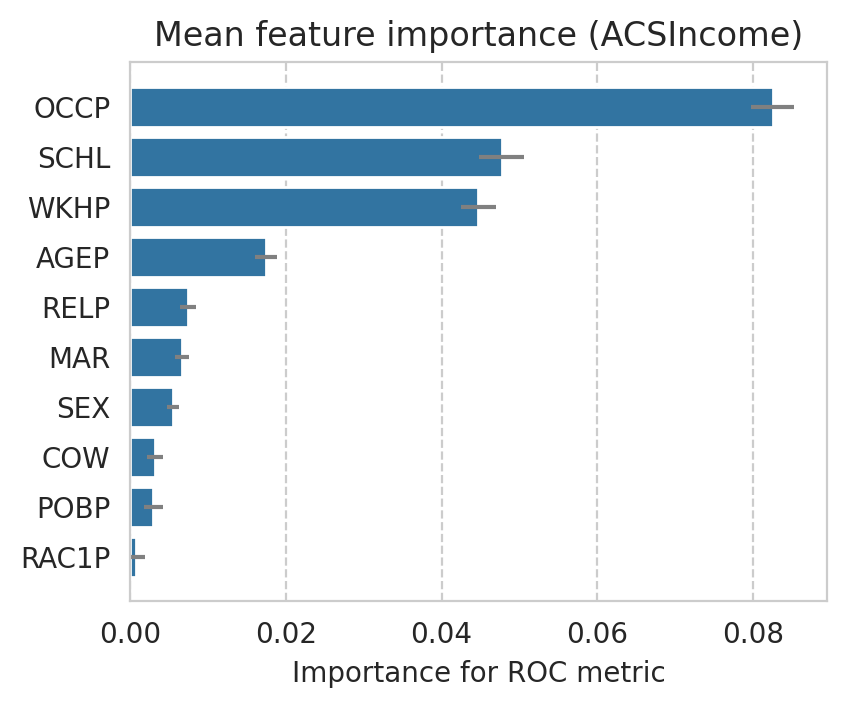

In [22]:
barplot_feat_imp(df[feat_imp_cols_sorted].mean(), df[feat_imp_std_cols_sorted].mean())
ax = plt.gca()
ax.set_xlim(left=0, right=ax.get_xlim()[-1])
save_fig(plt.gcf(), "mean-feat-imp")

In [23]:
def plot_feat_imp_subplots(df):
    N_COLS = 4
    N_ROWS = math.ceil(len(df) / N_COLS)

    cols_order = df[feat_imp_cols_sorted].mean().sort_values(ascending=False).index.tolist()
    std_cols_order = [col.replace("_imp_mean", "_imp_std") for col in cols_order]
    
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(12, 2.8 * N_ROWS), sharey=True, sharex=True)
    
    for idx, m in enumerate(df.index):
        ax_row = idx // N_COLS
        ax_col = idx % N_COLS
    
        ax = axes[ax_row, ax_col]
        row = df.loc[m]
        
        barplot_feat_imp(
            row[cols_order], stdev_values=row[std_cols_order],
            ax=ax,
            color=palette[0] if m not in baselines else palette[2],
        )
        
        ax.set_title(row["model_name"])

    # Set xlim
    max_xlim = max(ax_i.get_xlim()[-1] for ax_row in axes for ax_i in ax_row)
    axes[0,0].set_xlim(left=0, right=max_xlim)

    # Remove extra axes
    [axes[N_ROWS-1, N_COLS - 1 - i].remove() for i in range((N_ROWS * N_COLS) - len(df))];

    plt.plot()
    return fig

Feature importance for each model, plus baselines:

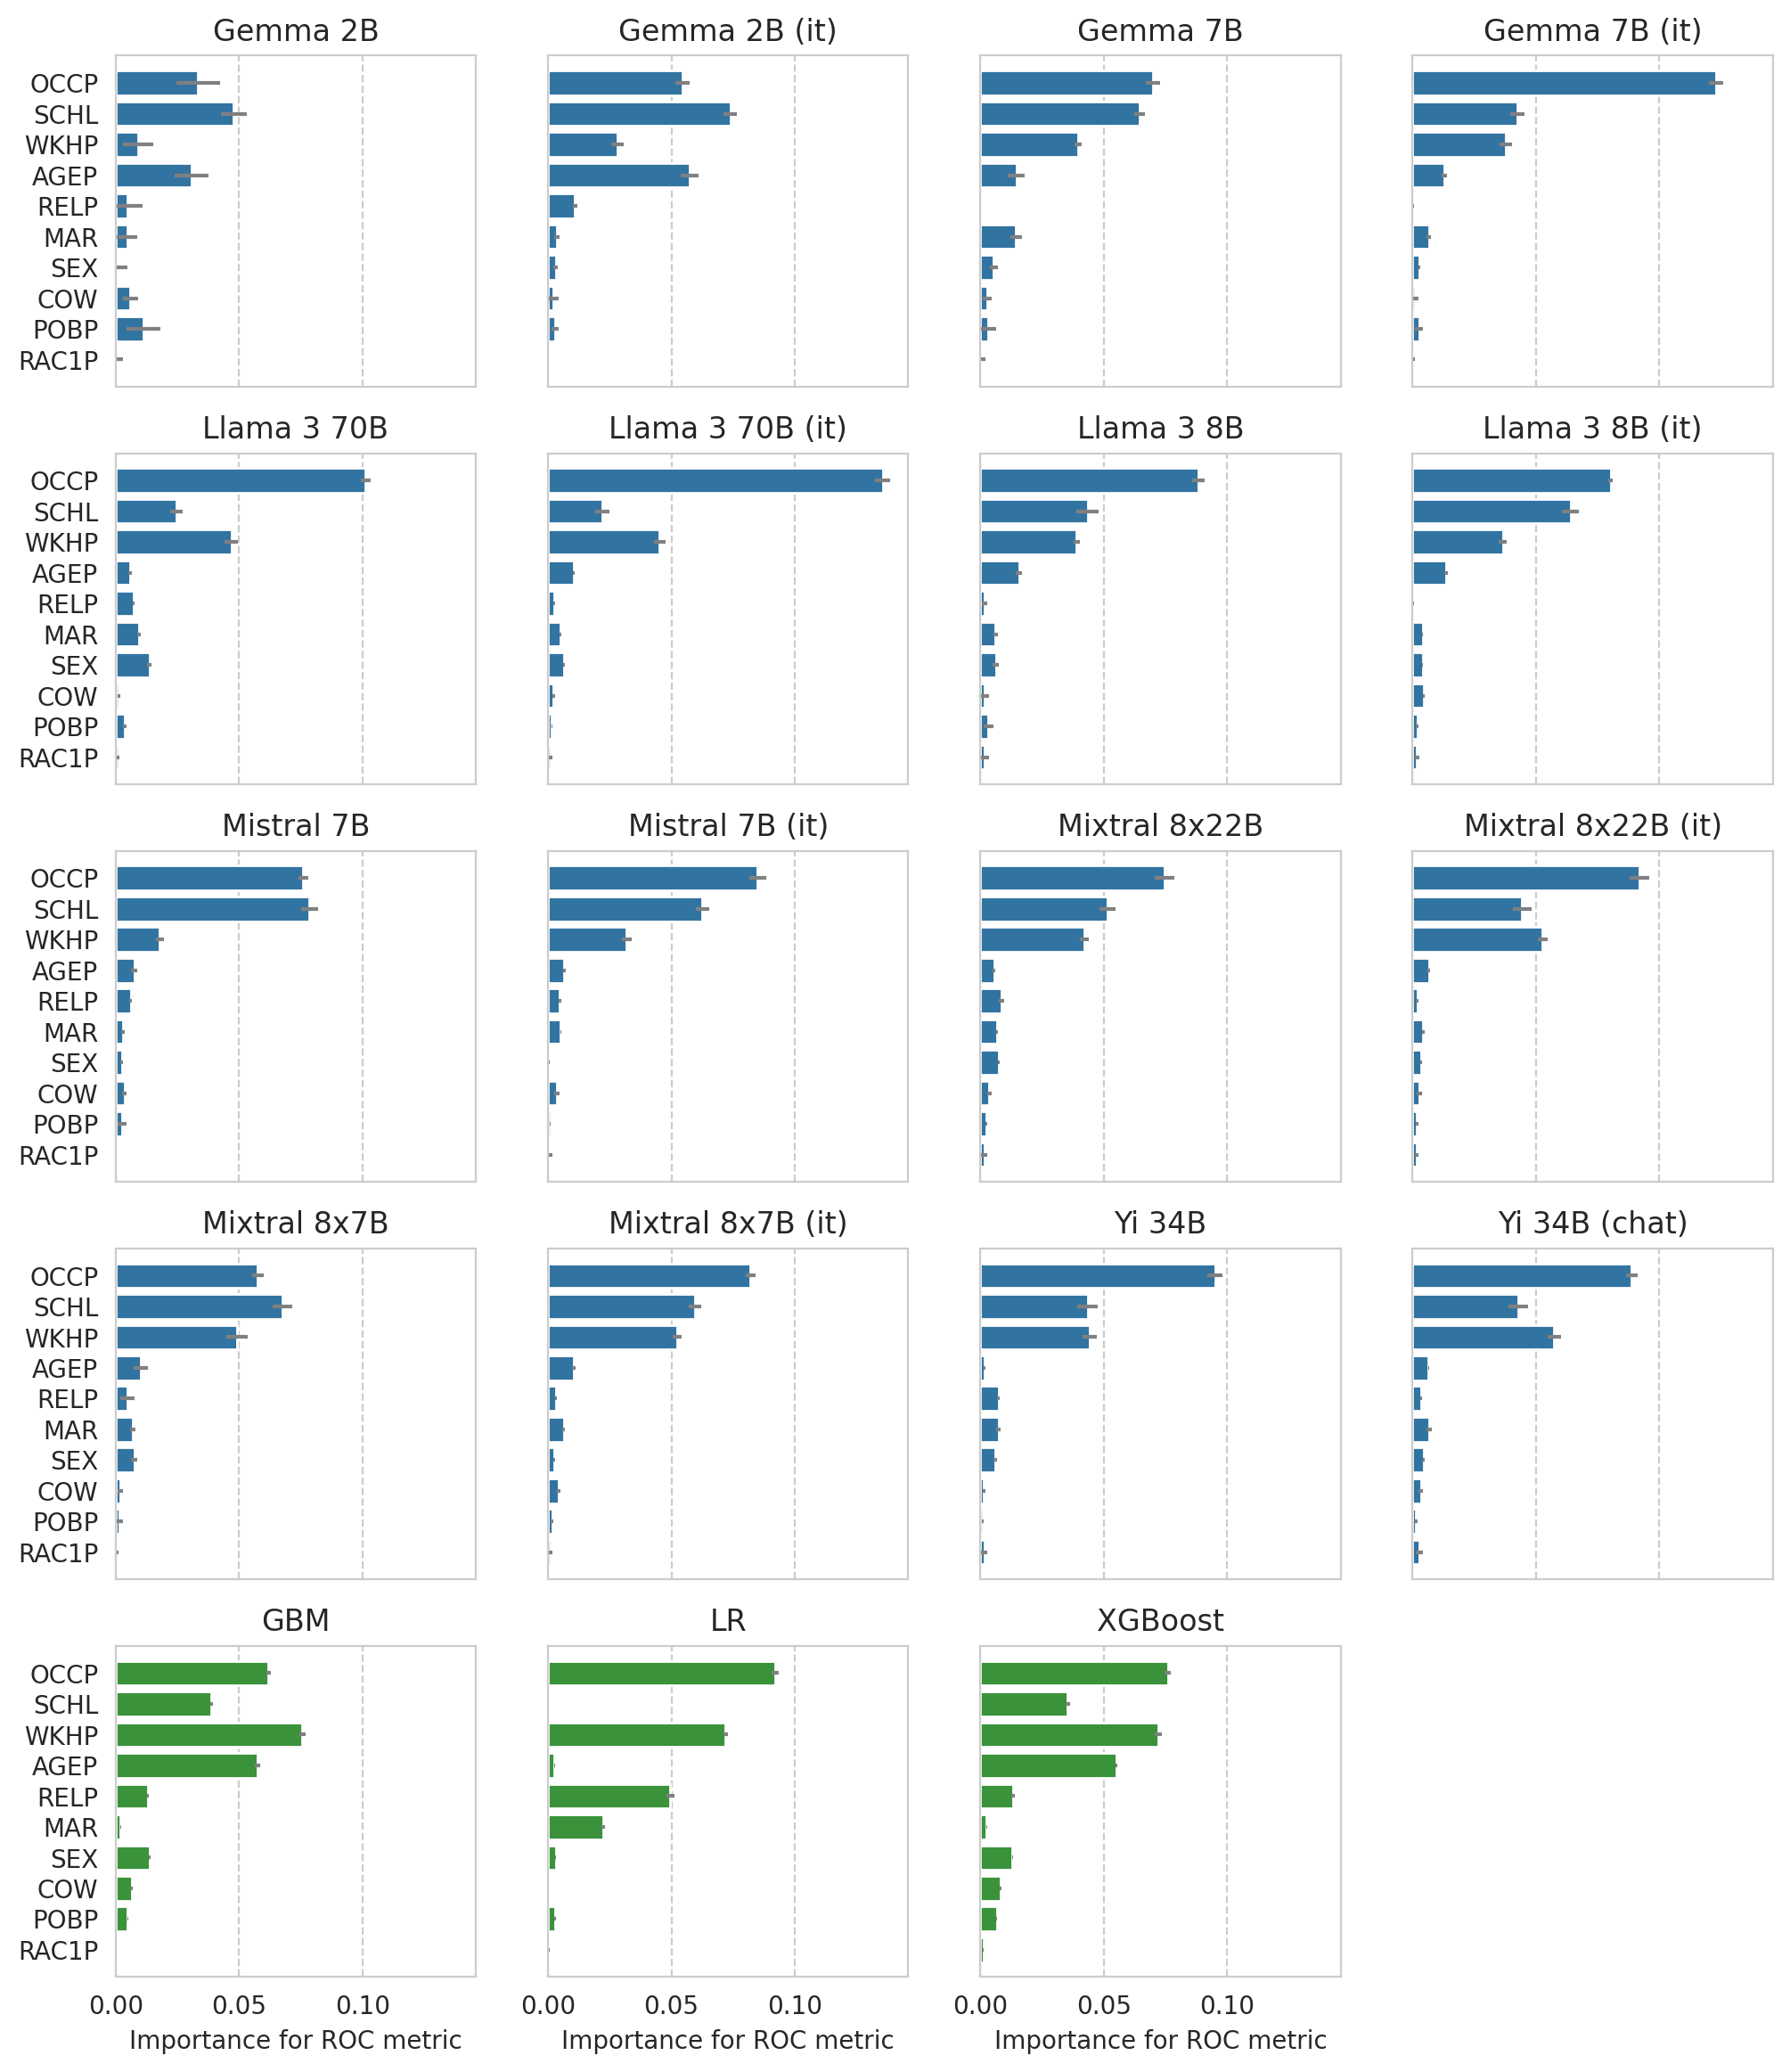

In [38]:
fig = plot_feat_imp_subplots(df)
save_fig(fig, "all-feat-imps")

In [31]:
from folktexts.llm_utils import get_model_size_B
large_models_filter = np.array([(get_model_size_B(m, default=-1) >= 40) for m in df.index])
# baselines_filter = np.array([(m in baselines) for m in df.index])
baselines_filter = np.array([(m == "XGBoost") for m in df.index])

ERROR:root:Could not infer model size from name 'GBM'
ERROR:root:Could not infer model size from name 'LR'
ERROR:root:Could not infer model size from name 'XGBoost'


Plot feature importance among large models (>= 40B):

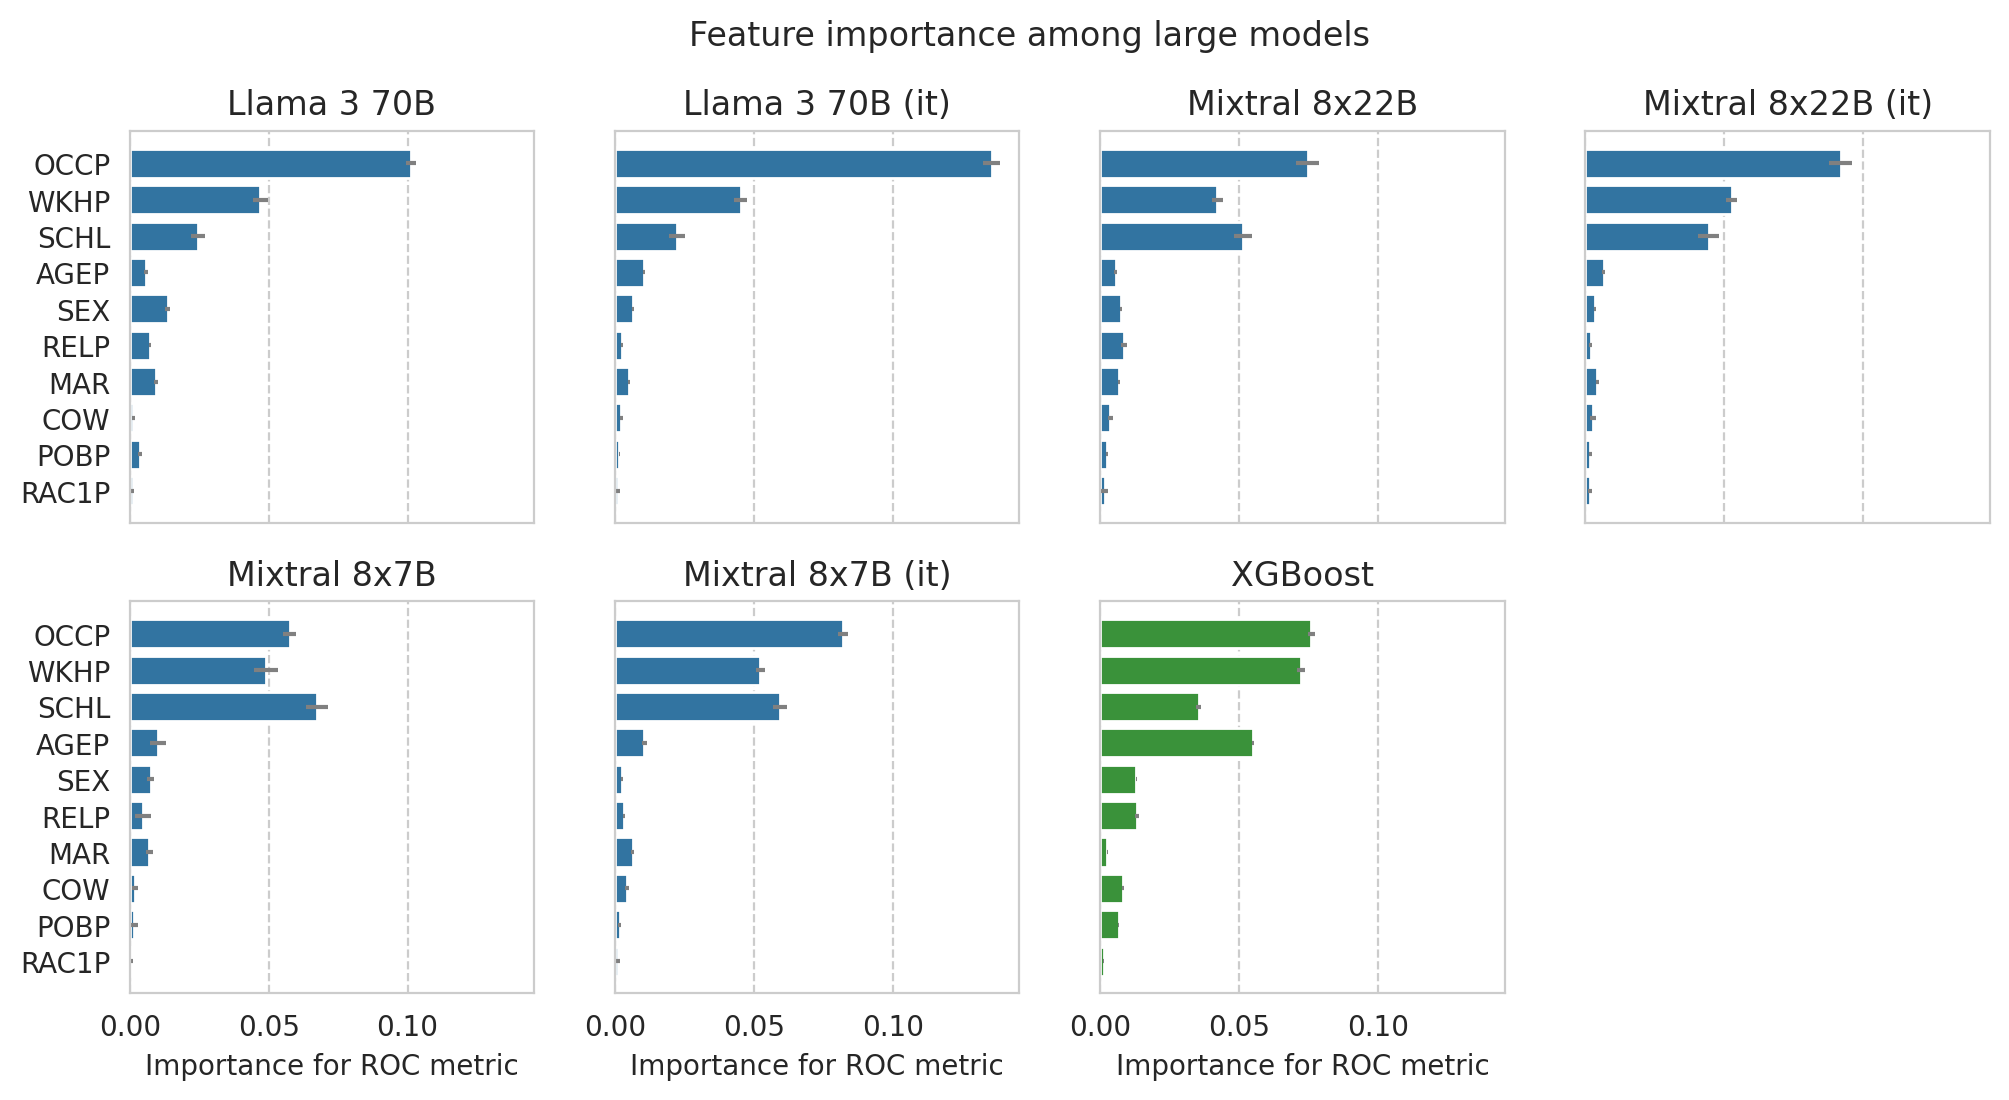

In [32]:
fig = plot_feat_imp_subplots(df[large_models_filter | baselines_filter])
plt.suptitle("Feature importance among large models")

save_fig(fig, "feat-imps-large-models")

Feature importance averaged among all large models:

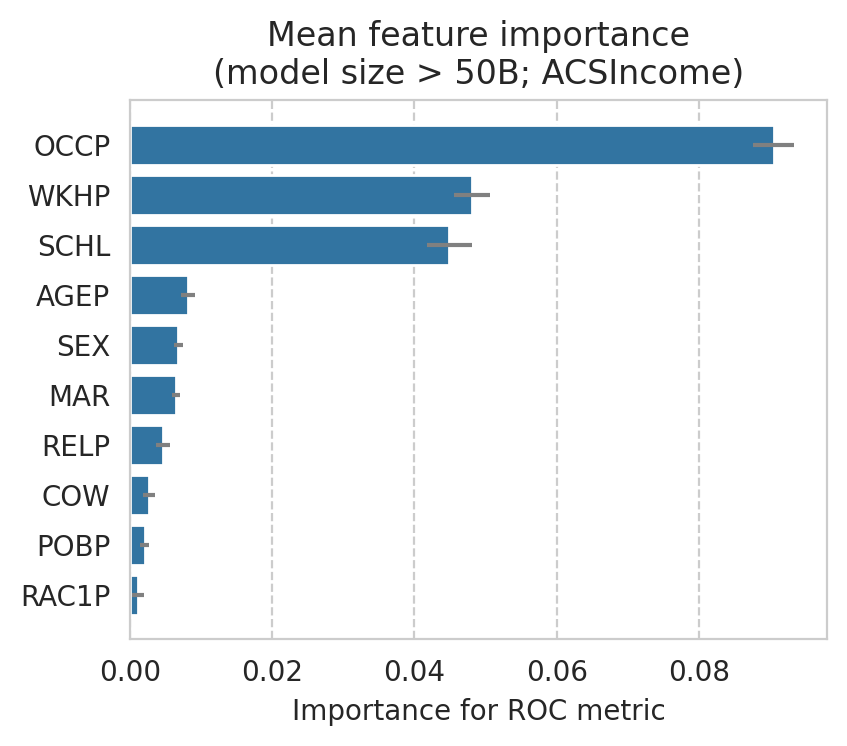

In [33]:
cols_order = df[large_models_filter][feat_imp_cols_sorted].mean().sort_values(ascending=False).index.tolist()
std_cols_order = [col.replace("_imp_mean", "_imp_std") for col in cols_order]

barplot_feat_imp(df[large_models_filter][cols_order].mean(), df[large_models_filter][std_cols_order].mean())
ax = plt.gca()
ax.set_xlim(left=0, right=ax.get_xlim()[-1])

plt.title("Mean feature importance\n(model size > 50B; ACSIncome)")
save_fig(fig, "mean-feat-imp-large-models")

Plot feature importance for each model separately:

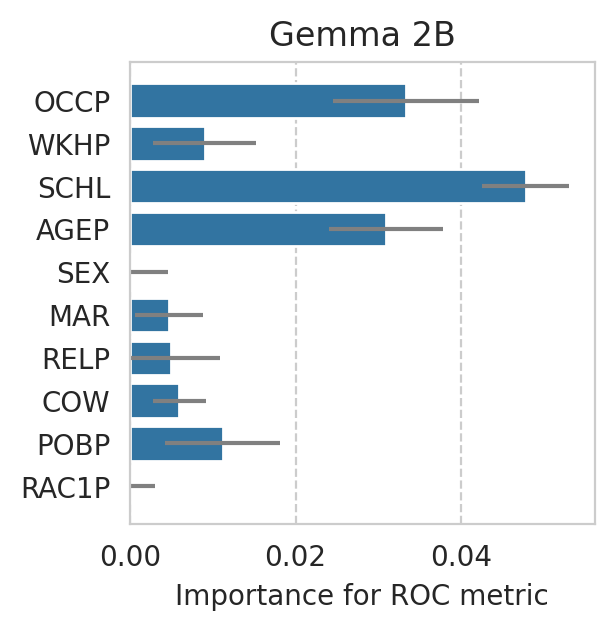

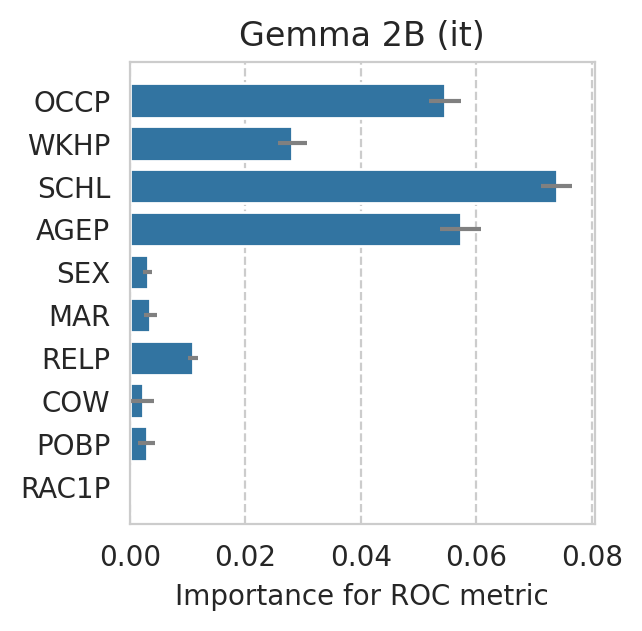

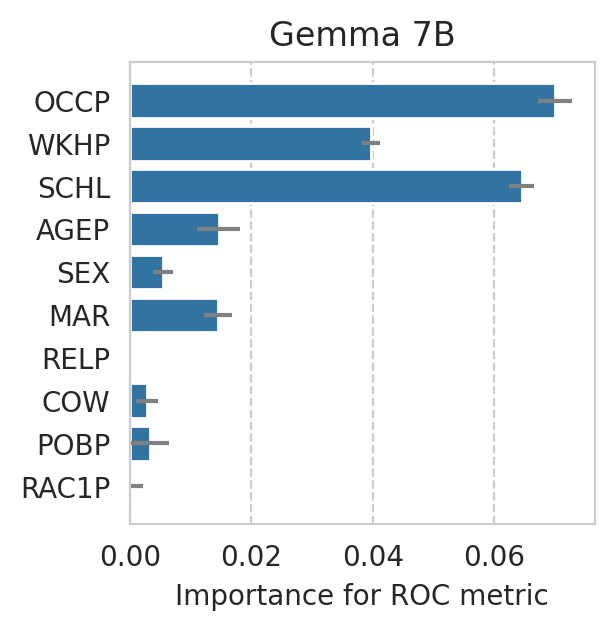

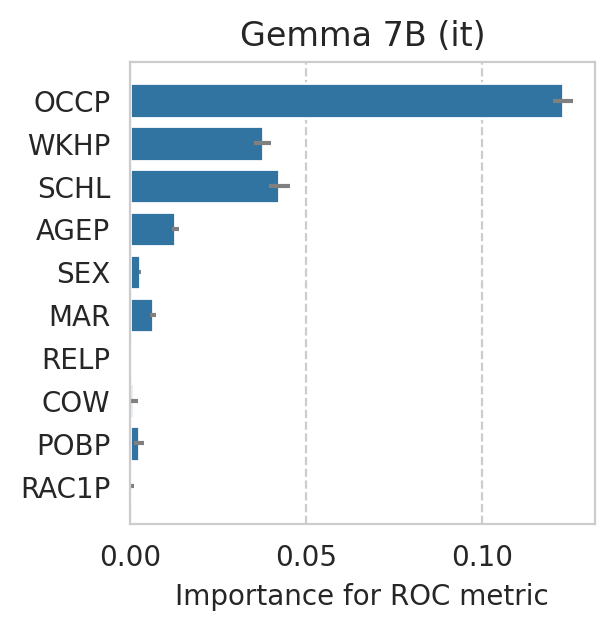

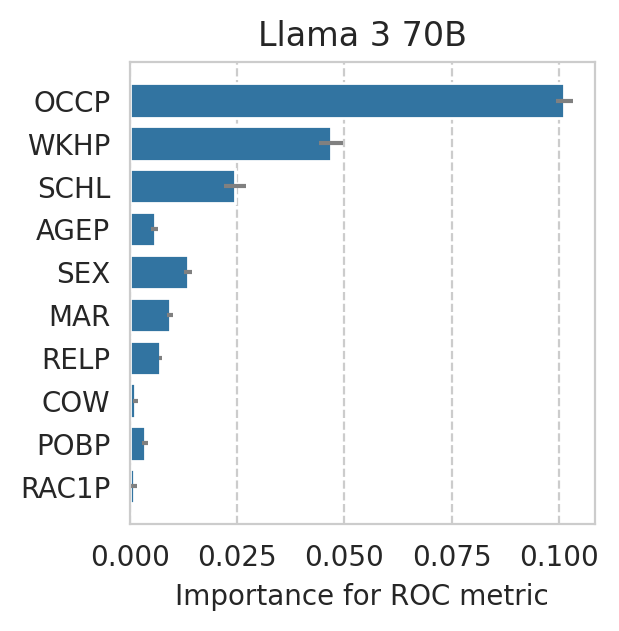

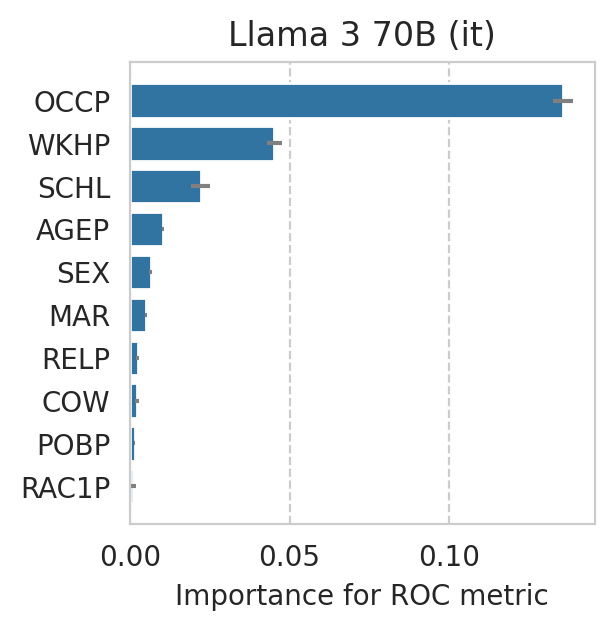

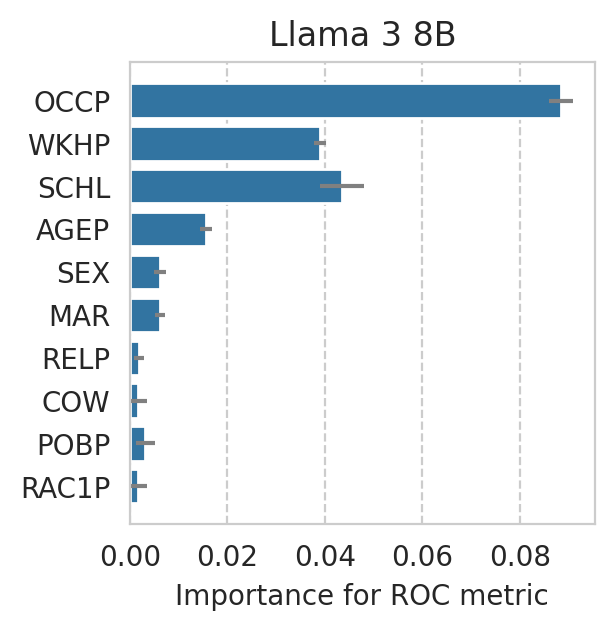

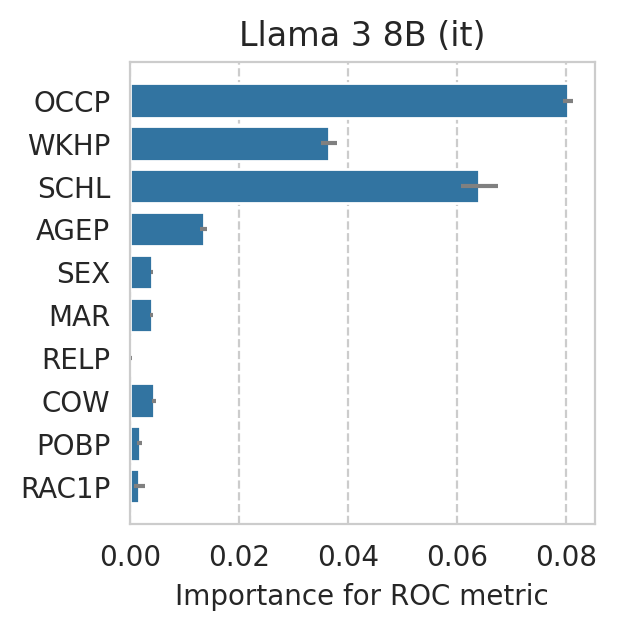

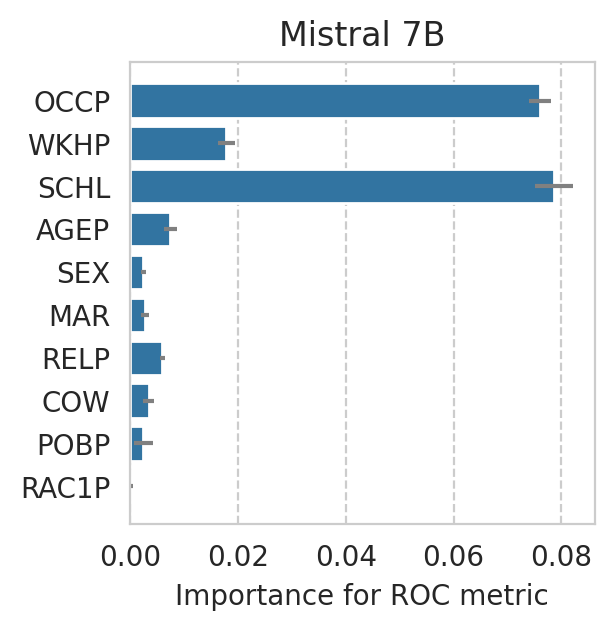

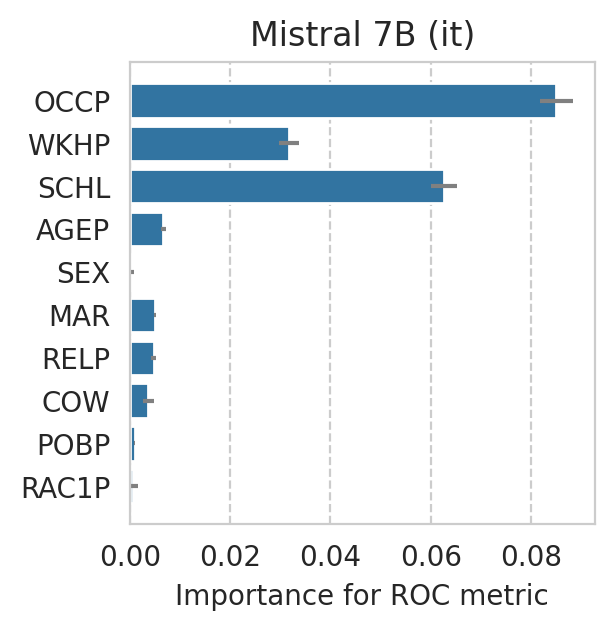

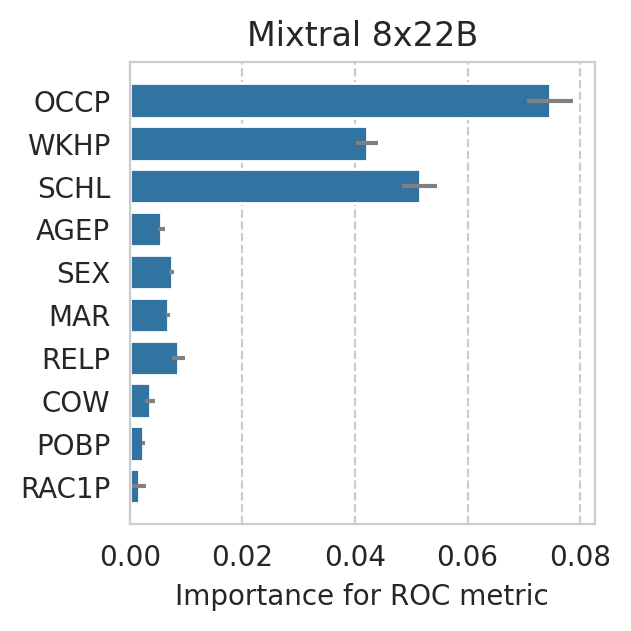

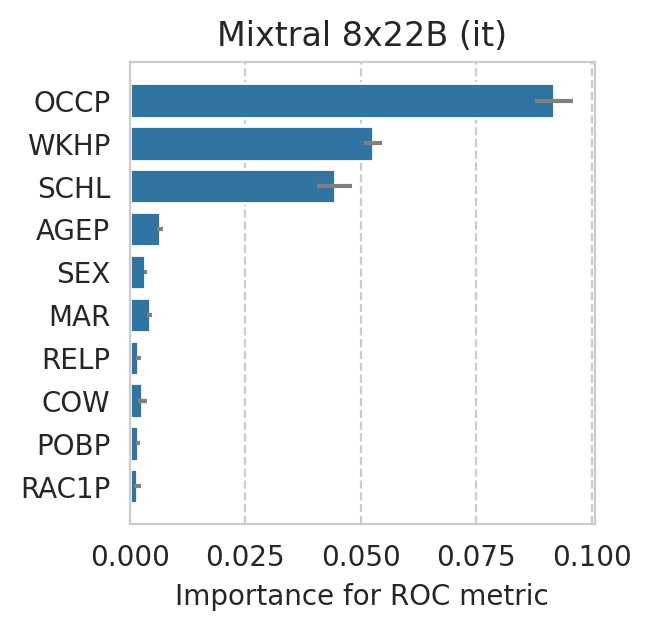

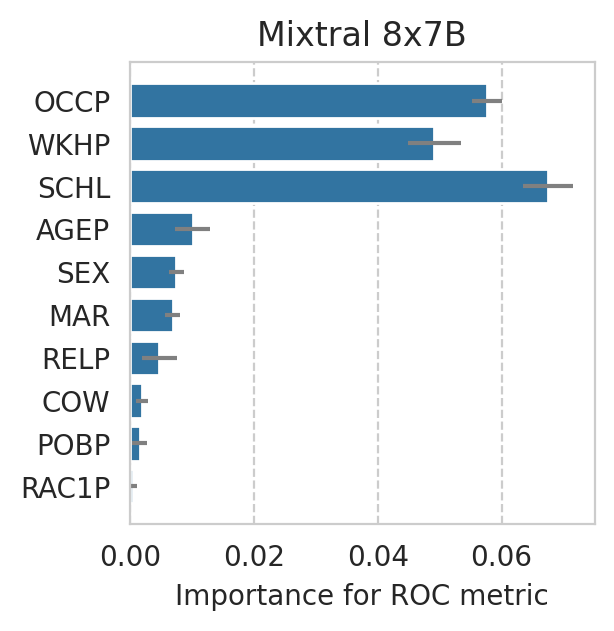

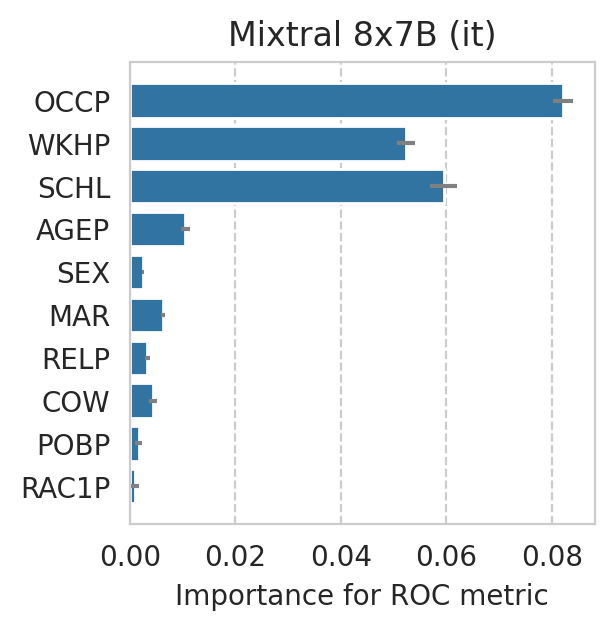

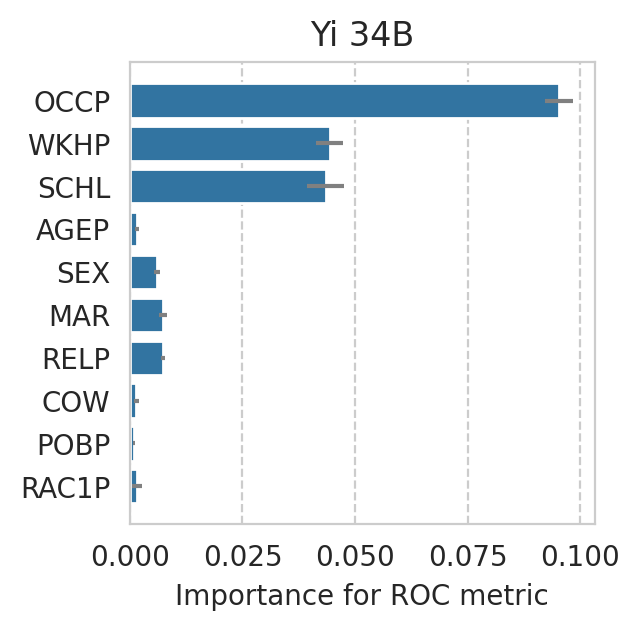

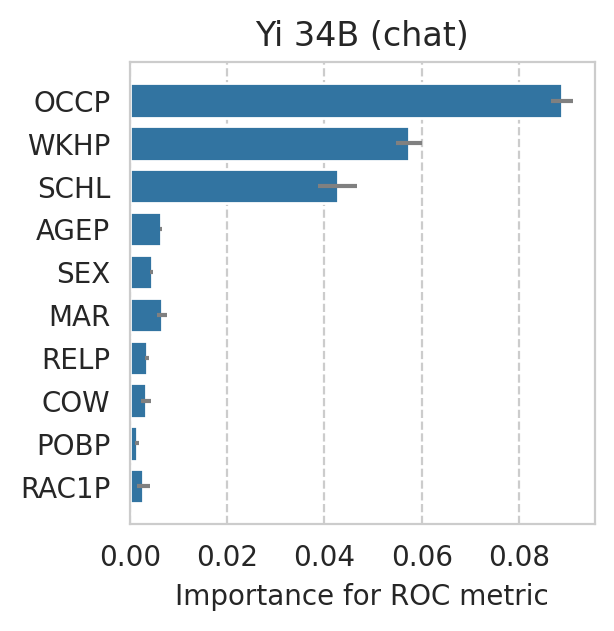

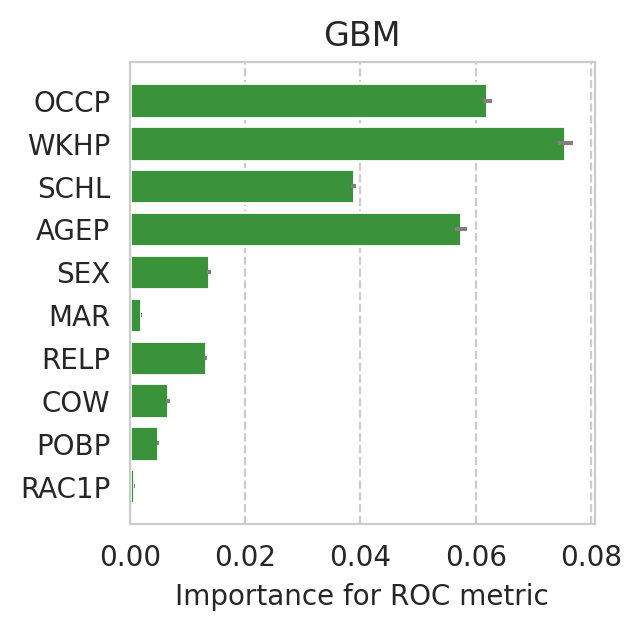

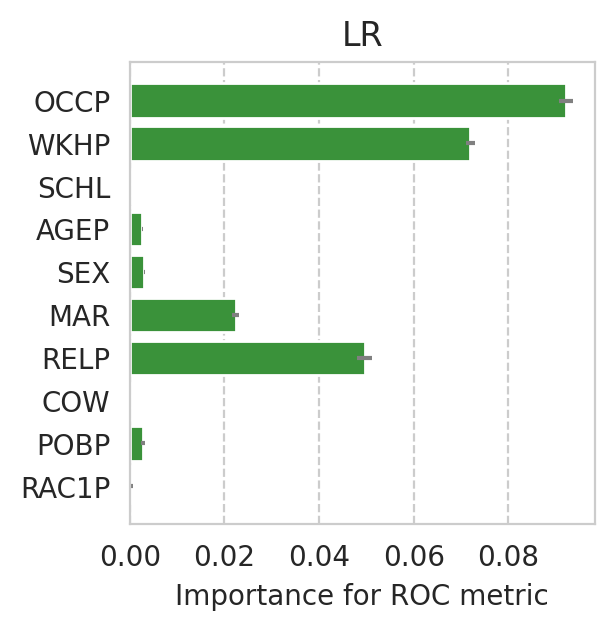

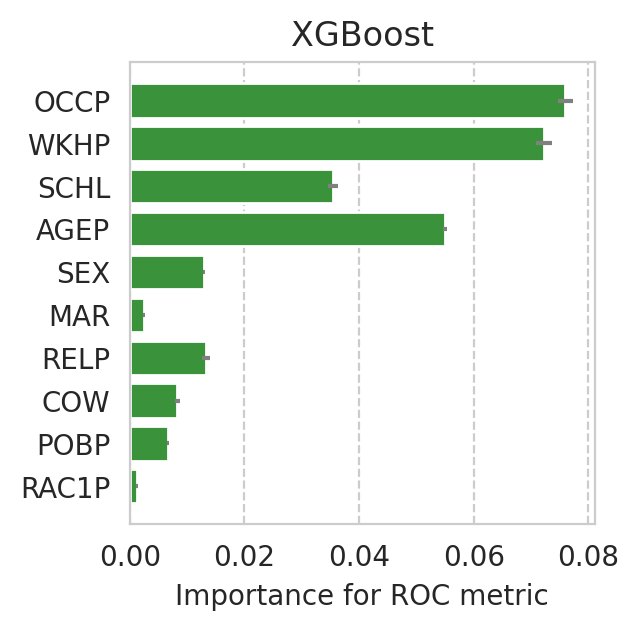

In [28]:
for idx, row in df.iterrows():
    fig, ax = plt.subplots(figsize=(3,3))

    barplot_feat_imp(
        row[cols_order], row[std_cols_order], ax=ax,
        color=palette[0] if row["model_name"] not in baselines else palette[2],
    )
    ax.set_title(row["model_name"])

    ax.set_xlim(left=0, right=ax.get_xlim()[-1])

    save_fig(fig, f"feat-imp_{idx}")
    plt.plot()
    # plt.close(fig)

---